# Notebook 05 — Feature Engineering & Modell-Erweiterungen (Anforderungen 6–8)

**Input:** `data/processed/model_ready.csv`  
**Target:** `moving_time` (Sekunden)

Aus Notebook 04 wissen wir:
- Baseline (Poly2 + Ridge, NO-LEAK) generalisiert gut, aber Fehler steigen bei langen/bergigen Fahrten.
- Stop-/Pausenverhalten erklärt einen Teil der Ausreißer, darf aber nicht als Feature genutzt werden (Leakage).

Ziele:
1) Leakage-sicheres Feature Engineering (physikalisch/plausibel)
2) Vergleich eines flexibleren Tabular-Modells (z. B. Gradient Boosting) gegen die Baseline
3) Evaluation via Cross-Validation (vergleichbar zu Notebook 03) und optional Hold-out Check

**Outputs:**
- CV-Ergebnistabellen nach `data_derived/`
- Plots nach `plots/`


In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import HistGradientBoostingRegressor

SEED = 42
np.random.seed(SEED)

CWD = Path.cwd()
REPO_ROOT = CWD.parent if CWD.name == "notebooks" else CWD

PATH_MODEL_READY = REPO_ROOT / "data" / "processed" / "model_ready.csv"
PATH_PLOTS = REPO_ROOT / "plots"
PATH_DERIVED = REPO_ROOT / "data_derived"

PATH_PLOTS.mkdir(parents=True, exist_ok=True)
PATH_DERIVED.mkdir(parents=True, exist_ok=True)

def savefig(filename: str) -> None:
    out = PATH_PLOTS / filename
    plt.tight_layout()
    plt.savefig(out, dpi=300, bbox_inches="tight")

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

scoring = {
    "mae": make_scorer(mean_absolute_error, greater_is_better=False),
    "rmse": make_scorer(rmse, greater_is_better=False),
    "r2": make_scorer(r2_score),
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


In [2]:
if not PATH_MODEL_READY.exists():
    raise FileNotFoundError(f"model_ready.csv not found at: {PATH_MODEL_READY}")

df = pd.read_csv(PATH_MODEL_READY)
print("Loaded model_ready:", df.shape)
display(df.head())

TARGET = "moving_time"

# Base NO-LEAK features
base = ["distance", "total_elevation_gain", "highest_elevation", "lowest_elevation"]
base = [c for c in base if c in df.columns]

df_fe = df.copy()

# Leak-safe engineered features
df_fe["distance_km"] = df_fe["distance"] / 1000.0
df_fe["elev_gain_per_km"] = df_fe["total_elevation_gain"] / (df_fe["distance_km"].replace(0, np.nan))
df_fe["elev_range"] = df_fe["highest_elevation"] - df_fe["lowest_elevation"]

# Optional: cap extreme engineered values for stability (winsorize-like)
df_fe["elev_gain_per_km"] = df_fe["elev_gain_per_km"].clip(upper=df_fe["elev_gain_per_km"].quantile(0.99))

FEATURES_FE = base + ["distance_km", "elev_gain_per_km", "elev_range"]
FEATURES_FE = [c for c in FEATURES_FE if c in df_fe.columns]

print("FEATURES_FE:", FEATURES_FE)

X = df_fe[FEATURES_FE].copy()
y = df_fe[TARGET].copy()


Loaded model_ready: (9039, 10)


,distance,elapsed_time,highest_elevation,lowest_elevation,moving_time,total_elevation_gain,stop_time,stop_ratio,avg_speed_implied_kmh,pace_min_per_km
0,102977.0,15212,476.6,241.6,14505,968.0,707,0.046476,25.557890,2.347612
1,64046.5,10964,394.8,221.2,9097,768.0,1867,0.170285,25.345433,2.367290
2,38853.7,5271,68.4,-27.4,5271,162.0,0,0.000000,26.536392,2.261046
3,39075.8,6634,57.8,-28.2,4813,79.0,1821,0.274495,29.227692,2.052848
4,51232.3,7491,228.6,-10.2,7491,608.0,0,0.000000,24.621049,2.436939


FEATURES_FE: ['distance', 'total_elevation_gain', 'highest_elevation', 'lowest_elevation', 'distance_km', 'elev_gain_per_km', 'elev_range']


## Modellvergleich: Baseline vs Feature Engineering vs flexibles Modell

Wir vergleichen per 5-Fold CV (gleiche Metriken wie zuvor):

A) **Baseline**: Poly2 + Ridge (alpha=1e-4) mit NO-LEAK Base-Features  
B) **Baseline + FE**: Poly2 + Ridge (alpha=1e-4) mit engineered Features  
C) **Histogram Gradient Boosting** (Tabular-Modell) mit engineered Features

Ziel: Prüfen, ob Feature Engineering und/oder ein flexibleres Modell die MAE auf CV verbessert,
ohne leakage zu nutzen.


In [4]:
def eval_model(name: str, model, X: pd.DataFrame, y: pd.Series) -> dict:
    res = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    return {
        "model": name,
        "mae_mean": -res["test_mae"].mean(),
        "mae_std": res["test_mae"].std(),
        "rmse_mean": -res["test_rmse"].mean(),
        "rmse_std": res["test_rmse"].std(),
        "r2_mean": res["test_r2"].mean(),
        "r2_std": res["test_r2"].std(),
    }

# Feature sets
FEATURES_BASE = [c for c in ["distance", "total_elevation_gain", "highest_elevation", "lowest_elevation"] if c in df_fe.columns]

X_base = df_fe[FEATURES_BASE].copy()
X_fe = df_fe[FEATURES_FE].copy()
y = df_fe[TARGET].copy()

# Baseline model: Poly2 + Ridge
poly2_ridge = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("ridge", Ridge(alpha=1e-4, random_state=SEED)),
])

# Flexible tabular model: HistGradientBoostingRegressor
# (handles nonlinearity & interactions without explicit polynomial expansion)
hgbr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=SEED,
        loss="squared_error",
        max_depth=6,
        learning_rate=0.1,
        max_iter=300,
    )),
])


,model,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std
2,C) HistGBR (base+FE),566.699887,22.293557,1080.513761,53.854336,0.940559,0.004818
1,B) Poly2+Ridge (base+FE),704.656371,24.829635,1264.911285,48.237035,0.918608,0.004399
0,A) Poly2+Ridge (base),707.385571,24.193510,1267.547964,47.751912,0.918267,0.004387


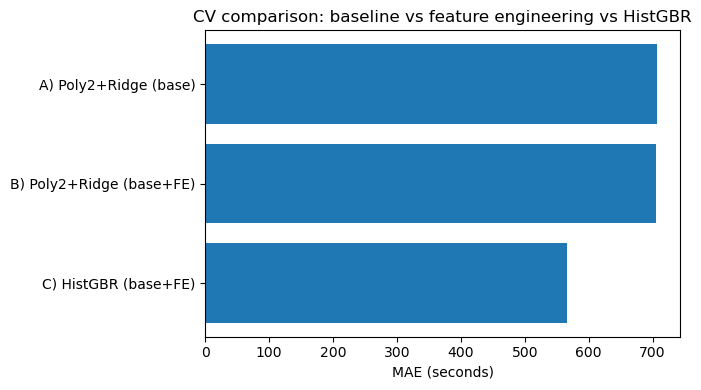

In [5]:
results = []
results.append(eval_model("A) Poly2+Ridge (base)", poly2_ridge, X_base, y))
results.append(eval_model("B) Poly2+Ridge (base+FE)", poly2_ridge, X_fe, y))
results.append(eval_model("C) HistGBR (base+FE)", hgbr, X_fe, y))

results_df = pd.DataFrame(results).sort_values("mae_mean")
display(results_df)

results_df.to_csv(PATH_DERIVED / "40_cv_results_feature_engineering_models.csv", index=False)

# Plot MAE comparison
plt.figure(figsize=(7, 4))
plt.barh(results_df["model"], results_df["mae_mean"])
plt.xlabel("MAE (seconds)")
plt.title("CV comparison: baseline vs feature engineering vs HistGBR")
savefig("40_cv_model_comparison_fe_mae.png")
plt.show()


## Kontrolliertes Hyperparameter-Tuning (HistGBR)

Statt einer großen GridSearch testen wir wenige plausible Varianten, um:
- Robustheit zu prüfen
- Overfitting-Risiko zu kontrollieren
- Rechenzeit klein zu halten

Getestet werden Kombinationen aus:
- max_depth ∈ {3, 6, None}
- learning_rate ∈ {0.05, 0.1}
- max_iter ∈ {300, 600}


In [ ]:
candidates = [
    {"max_depth": 3, "learning_rate": 0.1, "max_iter": 300},
    {"max_depth": 6, "learning_rate": 0.1, "max_iter": 300},  # current
    {"max_depth": None, "learning_rate": 0.1, "max_iter": 300},
    {"max_depth": 3, "learning_rate": 0.05, "max_iter": 600},
    {"max_depth": 6, "learning_rate": 0.05, "max_iter": 600},
    {"max_depth": None, "learning_rate": 0.05, "max_iter": 600},
]

tuning_results = []
for cfg in candidates:
    model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", HistGradientBoostingRegressor(
            random_state=SEED,
            loss="squared_error",
            max_depth=cfg["max_depth"],
            learning_rate=cfg["learning_rate"],
            max_iter=cfg["max_iter"],
        )),
    ])
    name = f"HistGBR depth={cfg['max_depth']} lr={cfg['learning_rate']} it={cfg['max_iter']}"
    tuning_results.append(eval_model(name, model, X_fe, y))

tuning_df = pd.DataFrame(tuning_results).sort_values("mae_mean")
display(tuning_df)

tuning_df.to_csv(PATH_DERIVED / "41_cv_histgbr_small_tuning.csv", index=False)

,model,mae_mean,mae_std,rmse_mean,rmse_std,r2_mean,r2_std
4,HistGBR depth=6 lr=0.05 it=600,565.070781,22.009746,1076.869728,52.613901,0.940938,0.004999
5,HistGBR depth=None lr=0.05 it=600,565.246982,22.416589,1088.950171,54.413065,0.939638,0.004778
1,HistGBR depth=6 lr=0.1 it=300,566.699887,22.293557,1080.513761,53.854336,0.940559,0.004818
2,HistGBR depth=None lr=0.1 it=300,567.520529,24.350554,1093.425999,54.663702,0.939163,0.004522
3,HistGBR depth=3 lr=0.05 it=600,581.683013,22.950415,1085.808998,42.663838,0.939986,0.004008
0,HistGBR depth=3 lr=0.1 it=300,581.724623,23.289852,1088.044437,43.004205,0.939745,0.003943


In [ ]:
best_row = tuning_df.iloc[0]
best_model_name = best_row["model"]
print("Best HistGBR:", best_model_name)
print("Best CV MAE:", best_row["mae_mean"])

Best HistGBR: HistGBR depth=6 lr=0.05 it=600
Best CV MAE: 565.0707807622578


## Hold-out Check für das beste HistGBR-Setup

Nach der CV-Auswahl prüfen wir die Generalisierung auf einem unabhängigen Testsplit
(analog Notebook 04), um sicherzustellen, dass die Performanceverbesserung nicht nur CV-Varianz ist.

Hinweis: Das Feature-Set bleibt leakage-sicher (Base + engineered Features).


In [8]:
from sklearn.model_selection import train_test_split

X = X_fe.copy()
y = df_fe[TARGET].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED
)

best_hgbr = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=SEED,
        loss="squared_error",
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
    )),
])

best_hgbr.fit(X_train, y_train)
y_pred = best_hgbr.predict(X_test)

metrics = {
    "model": "HistGBR depth=6 lr=0.05 it=600",
    "n_train": len(X_train),
    "n_test": len(X_test),
    "mae": mean_absolute_error(y_test, y_pred),
    "rmse": rmse(y_test, y_pred),
    "r2": r2_score(y_test, y_pred),
}

metrics_df = pd.DataFrame([metrics])
display(metrics_df)
metrics_df.to_csv(PATH_DERIVED / "42_holdout_metrics_histgbr.csv", index=False)


,model,n_train,n_test,mae,rmse,r2
0,HistGBR depth=6 lr=0.05 it=600,7231,1808,598.4133,1135.138186,0.93724


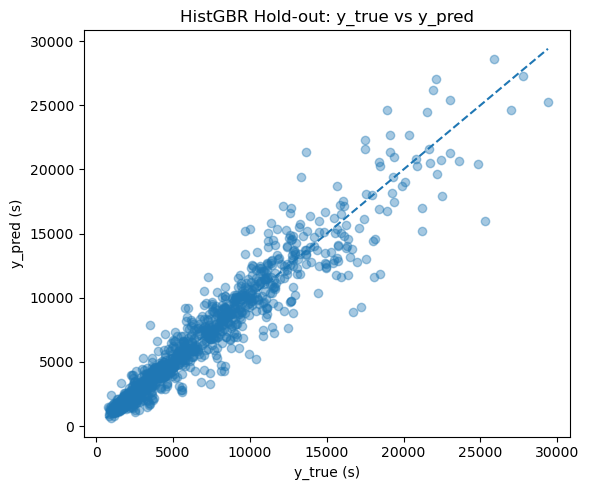

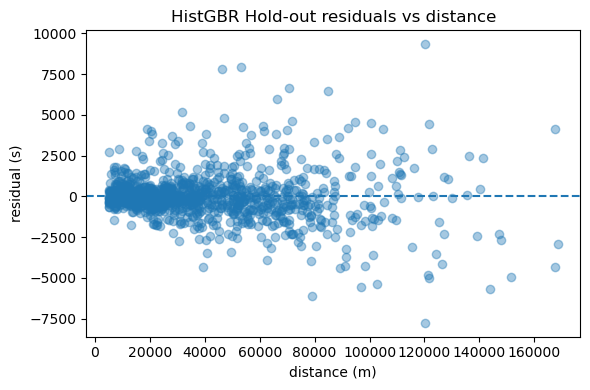

In [9]:
pred = X_test.copy()
pred["y_true"] = y_test.values
pred["y_pred"] = y_pred
pred["residual"] = pred["y_true"] - pred["y_pred"]
pred["abs_error"] = pred["residual"].abs()

pred.to_csv(PATH_DERIVED / "43_holdout_predictions_histgbr.csv", index=False)

# y_true vs y_pred
plt.figure(figsize=(6, 5))
plt.scatter(pred["y_true"], pred["y_pred"], alpha=0.4)
mn = min(pred["y_true"].min(), pred["y_pred"].min())
mx = max(pred["y_true"].max(), pred["y_pred"].max())
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("y_true (s)")
plt.ylabel("y_pred (s)")
plt.title("HistGBR Hold-out: y_true vs y_pred")
savefig("41_histgbr_holdout_ytrue_vs_ypred.png")
plt.show()

# residuals vs distance
plt.figure(figsize=(6, 4))
plt.scatter(pred["distance"], pred["residual"], alpha=0.4)
plt.axhline(0, linestyle="--")
plt.xlabel("distance (m)")
plt.ylabel("residual (s)")
plt.title("HistGBR Hold-out residuals vs distance")
savefig("42_histgbr_holdout_residuals_vs_distance.png")
plt.show()


## Modellauswahl (Ergebnis Notebook 05)

Ergebnis:
- Feature Engineering allein verbessert die lineare/polynomiale Baseline kaum.
- Ein flexibles Tree-Ensemble (HistGBR) verbessert die Performance deutlich und robust (CV + Hold-out).

**Finales Modell (Champion):**
HistGBR mit `max_depth=6`, `learning_rate=0.05`, `max_iter=600` auf leakage-sicheren Features (Base + engineered).

**Baseline (Referenz):**
Poly2 + Ridge (alpha=1e-4) bleibt als gut interpretierbare Vergleichsbasis dokumentiert.


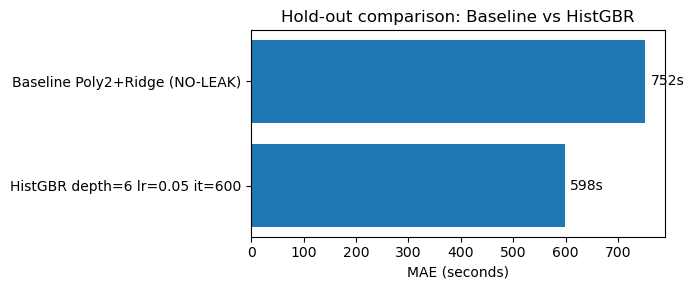

In [12]:
compare_holdout_sorted = compare_holdout.sort_values("mae", ascending=True)

plt.figure(figsize=(7, 3))
plt.barh(compare_holdout_sorted["model"], compare_holdout_sorted["mae"])
plt.xlabel("MAE (seconds)")
plt.title("Hold-out comparison: Baseline vs HistGBR")

# annotate values
for i, v in enumerate(compare_holdout_sorted["mae"].values):
    plt.text(v + 10, i, f"{v:.0f}s", va="center")

savefig("43_holdout_compare_baseline_vs_histgbr_mae.png")
plt.show()

In [11]:
import joblib

final_model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("model", HistGradientBoostingRegressor(
        random_state=SEED,
        loss="squared_error",
        max_depth=6,
        learning_rate=0.05,
        max_iter=600,
    )),
])

final_model.fit(X_fe, y)

PATH_MODEL = REPO_ROOT / "src" / "models"
PATH_MODEL.mkdir(parents=True, exist_ok=True)

model_path = PATH_MODEL / "histgbr_final.joblib"
joblib.dump(final_model, model_path)
print("Saved final model to:", model_path)


Saved final model to: /Users/justuspfeifer/Documents/AML/aml-justus-pfeifer/src/models/histgbr_final.joblib
